In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.callbacks import CSVLogger
from keras.callbacks import ProgbarLogger
from numpy import mean
from numpy import std
from keras import backend as K
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback
import six, csv
from collections import OrderedDict, Iterable
from keras import optimizers
from keras.layers import Dropout
from sklearn.metrics import precision_score 

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

# LSTM Model (Regession)

### Import dataset

In [2]:
# loading the datasets
sc_x_train = np.load('sc_x_train_sm3.npy')
sc_y_train = np.load('sc_y_train_sm3.npy')
sc_x_test = np.load('sc_x_test.npy')
sc_y_test = np.load('sc_y_test.npy')
y_test = np.load('y_test.npy')
y_train = np.load('y_train.npy')
y_test_class = np.load('y_test_class.npy', allow_pickle = True)

In [3]:
# formatting target values for model
sc_y_train = sc_y_train.flatten()
sc_y_test = sc_y_test.flatten()
print(sc_y_train.shape)
print(sc_y_test.shape)

(19325,)
(3108,)


### Define model

In [4]:
# Metric def RMSE
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [5]:
# saving results per batch
class NBatchCSVLogger(Callback):
    """Callback that streams every batch results to a csv file.
    """
    def __init__(self, filename, separator=',', append=False):
        self.sep = separator
        self.filename = filename
        self.append = append
        self.writer = None
        self.keys = None
        self.append_header = True
        self.file_flags = 'b' if six.PY2 and os.name == 'nt' else ''
        super(NBatchCSVLogger, self).__init__()
    def on_train_begin(self, logs=None):
        if self.append:
            if os.path.exists(self.filename):
                with open(self.filename, 'r' + self.file_flags) as f:
                    self.append_header = not bool(len(f.readline()))
            self.csv_file = open(self.filename, 'a' + self.file_flags)
        else:
            self.csv_file = open(self.filename, 'w' + self.file_flags)
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, six.string_types):
                return k
            elif isinstance(k, Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k
        if self.keys is None:
            self.keys = sorted(logs.keys())
        if self.model.stop_training:
            logs = dict([(k, logs[k]) if k in logs else (k, 'NA') for k in self.keys])
        if not self.writer:
            class CustomDialect(csv.excel):
                delimiter = self.sep
            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=['batch'] + self.keys, dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()
        row_dict = OrderedDict({'batch': batch})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()
    def on_train_end(self, logs=None):
        self.csv_file.close()
        self.writer = None

In [6]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    #define model
    verbose, epochs, batch_size = 0, 100, 100 #trainX.shape[0]
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    model2 = Sequential()
    model2.add(LSTM(units = 20, activation='relu', return_sequences = True, input_shape=(n_timesteps,n_features), kernel_initializer = 'he_normal'))
    model2.add(Dropout(0.5))
    model2.add(LSTM(units = 10, activation='relu', kernel_initializer = 'he_normal'))
    model2.add(Dense(1))
    #opt = optimizers.Adam(learning_rate=0.1)
    model2.compile(loss='mse', metrics =[rmse], optimizer='adam')
    
    # fit network
    csv_logger = CSVLogger('training_data2.log')
    history = model2.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data = (testX, testy), callbacks=[csv_logger], verbose=verbose)
    out_batch = NBatchCSVLogger("batch_logs2.csv", separator=',', append=False)
    #historyb = model2.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, callbacks=[out_batch], verbose=verbose)
    
    # save everyhting for later
    wfname = "weights2.hdf5"
    fname = "model2.hdf5"
    model2.save_weights(wfname,overwrite = True)
    model2.save(fname, overwrite = True)
    
    # evaluate model
    mse = model2.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return mse

### Evalutation

In [7]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('RMSE:mean',m,'std+/-',s)

In [8]:
# running evaluation for a nunmber of times to summarize the results
scores = list()
def run_experiment(repeats=10):
    # repeat experiment
    for r in range(repeats):
        score = evaluate_model(sc_x_train, sc_y_train, sc_x_test, sc_y_test)
        #ensure that the metrics is rmse
        print('>#%d: %.3f' % (r+1, score[1]))
        scores.append(score[1])

run_experiment()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
>#1: 0.115
>#2: 0.126
>#3: 0.113
>#4: 0.113
>#5: 0.112
>#6: 0.123
>#7: 0.114
>#8: 0.115
>#9: 0.118
>#10: 0.120


In [9]:
re_scores = np.reshape(scores, (len(scores),1))
re_scores

array([[0.11488893],
       [0.12605947],
       [0.11259723],
       [0.11313444],
       [0.11220828],
       [0.1231207 ],
       [0.11390182],
       [0.11517711],
       [0.11795484],
       [0.12009753]])

In [10]:
# rescale the results
# inverse transform model predictions

scaler_out = MinMaxScaler()
scaler_out.fit(y_train)
rmse1 = scaler_out.inverse_transform(re_scores)

In [11]:
# summarize results
summarize_results(rmse1)

[[55.95217932]
 [61.25112089]
 [54.86507077]
 [55.1199053 ]
 [54.68056906]
 [59.85706438]
 [55.48392887]
 [56.08888299]
 [57.40654887]
 [58.42297117]]
RMSE:mean 56.91282416078111 std+/- 2.1458786369734764


### Plotting last fitting results

In [12]:
# loading last repetition of model
fname = "model2.hdf5"
model2 = load_model(fname, custom_objects={"rmse":rmse})

# Loading model training history 
history=pd.read_csv("training_data2.log")
historyb=pd.read_csv("batch_logs2.csv")

In [13]:
history

,epoch,loss,rmse,val_loss,val_rmse
0,0,0.022086,0.140803,0.014177,0.118281
1,1,0.014231,0.118780,0.013605,0.115933
2,2,0.013627,0.116053,0.013367,0.115240
3,3,0.013194,0.114439,0.013255,0.114507
4,4,0.012929,0.113285,0.013158,0.114227
...,...,...,...,...,...
95,95,0.010688,0.102677,0.014042,0.117943
96,96,0.010755,0.103244,0.014104,0.118389
97,97,0.010706,0.102793,0.014188,0.118829
98,98,0.010656,0.102752,0.013978,0.118009


In [14]:
historyb

,batch,batch.1,loss,rmse,size
0,0,0,0.022137,0.148784,32
1,1,1,0.013686,0.132887,32
2,2,2,0.018372,0.133772,32
3,3,3,0.019366,0.135119,32
4,4,4,0.012235,0.130218,32
...,...,...,...,...,...
773,384,384,0.002853,0.078367,32
774,385,385,0.014401,0.078475,32
775,386,386,0.004709,0.078449,32
776,387,387,0.004216,0.078414,32


In [15]:
print(model2.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 5, 20)             3360      
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 20)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________
None


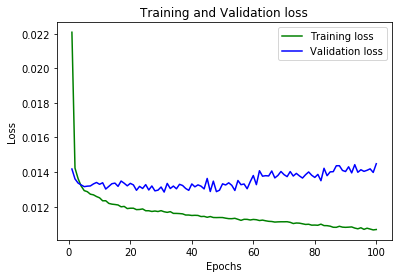

In [16]:
# check runs per epoch (loss)

loss_train = history['loss']
loss_val = history['val_loss']
epochs = range(1, len(history['epoch']) +1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

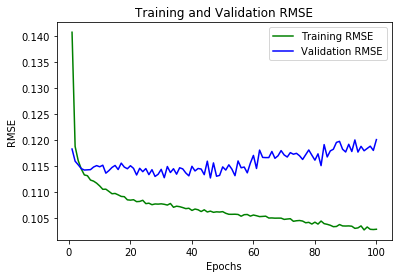

In [17]:
# check runs per epoch (rmse)

rmse_train = history['rmse']
rmse_val = history['val_rmse']
epochs = range(1,len(history['epoch']) +1)
plt.plot(epochs, rmse_train, 'g', label='Training RMSE')
plt.plot(epochs, rmse_val, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [18]:
len(historyb['batch'])

778

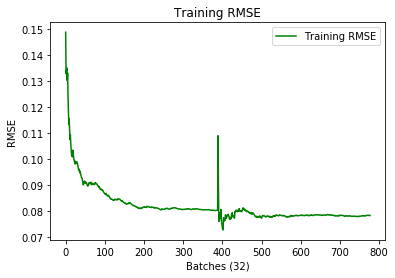

In [19]:
# check runs per batch (rmse)

rmse_train = historyb['rmse']
batch = range(0,len(historyb['batch']))
plt.plot(batch, rmse_train, 'g', label='Training RMSE')
plt.title('Training RMSE')
plt.xlabel('Batches (32)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Checking

In [20]:
#checking output of the model
model_prediction = model2.predict(sc_x_test, verbose = 0)

In [21]:
# inverse transform model predictions

scaler_out = MinMaxScaler()
scaler_out.fit(y_train)
report = scaler_out.inverse_transform(model_prediction)

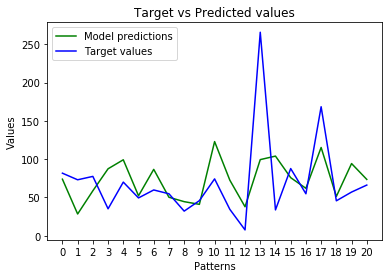

In [22]:
# plotting predictions

target = list(y_test.flatten())
prediction = list(report.flatten())
targe = target[0:21]
pred =prediction[0:21]
patterns = range(0,21)
plt.plot(patterns, pred, 'g', label='Model predictions')
plt.plot(patterns, targe, 'b', label='Target values')
plt.xticks(patterns)
plt.title('Target vs Predicted values')
plt.xlabel('Patterns')
plt.ylabel('Values')
plt.legend()
plt.show()

### Comparing to classification problem

In [23]:
# convert prediction set to classes

pred_class = np.empty((report.shape[0],report.shape[1]), dtype = 'O')

maxi = max(report[:,0])

for c in range(pred_class.shape[0]):
    if 0 <= report[c,0] <= 12:
        pred_class[c,0] = "good"
    if 12 < report[c,0] <= 35:
        pred_class[c,0] = "moderate"
    if 35 < report[c,0] <= 55:
        pred_class[c,0] = "unhealthy for sensitive groups"
    if 55 < report[c,0] <= 150:
        pred_class[c,0] = "unhealthy"
    if 150 < report[c,0] <= 250:
        pred_class[c,0] = "very unhealthy"
    if 250 < report[c,0] <= maxi:
        pred_class[c,0] = "hazardous"

In [24]:
predict = list(pred_class[:,0])

In [25]:
pre = precision_score(y_test_class, predict, labels=['good', 'hazardous', 'moderate', 'unhealthy', 'unhealthy for sensitive groups', 'very unhealthy'], average='micro')
print('> %.3f' % (pre * 100.0))

> 43.275


### Extreme cases

In [26]:
# extreme cases from 150 onwards
x_test_ex = np.reshape(sc_x_test, (sc_x_test.shape[0],sc_x_test.shape[1]*sc_x_test.shape[2]))
print(x_test_ex.shape)

(3108, 105)


In [27]:
checking = np.concatenate((x_test_ex, y_test), axis = 1)
extreme = checking[:,105:106]

In [28]:
checking2 = checking[extreme[:,0]>150]
print(checking2.shape)
checking3 = checking2[:,0:105]
print(checking3.shape)

(136, 106)
(136, 105)


In [29]:
checking4 = np.reshape(checking3, (checking3.shape[0],sc_x_test.shape[1], sc_x_test.shape[2]))
checking4.shape

(136, 5, 21)

In [30]:
extreme_predict = model2.predict(checking4, verbose = 0)

In [31]:
report2 = scaler_out.inverse_transform(extreme_predict)

In [32]:
checking5 = checking2[:,105:106]

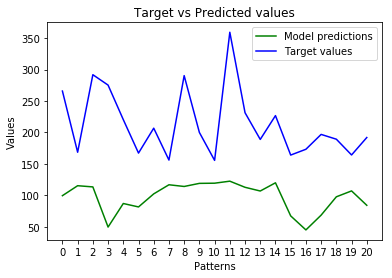

In [33]:
# plotting extreme predictions

target = list(checking5.flatten())
prediction = list(report2.flatten())
targe = target[0:21]
pred =prediction[0:21]
patterns = range(0,21)
plt.plot(patterns, pred, 'g', label='Model predictions')
plt.plot(patterns, targe, 'b', label='Target values')
plt.xticks(patterns)
plt.title('Target vs Predicted values')
plt.xlabel('Patterns')
plt.ylabel('Values')
plt.legend()
plt.show()